<a href="https://colab.research.google.com/github/yisiszhang/AdvancedPython/blob/main/colab/Lecture5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lecture 5: Neural network I**

# 5.1 Multidimensional data and nonlinear classification
Neural network is desirable for solving complex *classification* tasks. Why?

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
http://yann.lecun.com/exdb/mnist/

In [ ]:
# There are multiple ways to load the MNIST dataset. Here demonstrates how to do it through pytorch
from torchvision.datasets import MNIST

# load (download if needed) the MNIST dataset
mnist_train = MNIST(".", train=True, download=True)

# select a data # (0-59999) to visualize

# each data is a 28x28 image
# select a data index
ind = 10
#print(mnist_train.data[ind]) 
print(mnist_train.data[ind].shape)

# image label
print(mnist_train.targets[ind])

# total number of data
print(len(mnist_train))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

torch.Size([28, 28])
tensor(3)
60000


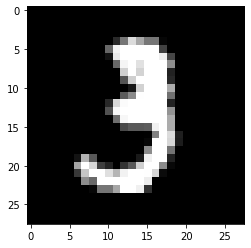

In [ ]:
# visualize this image
plt.imshow(mnist_train.data[ind], cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

torch.Size([60000, 784])


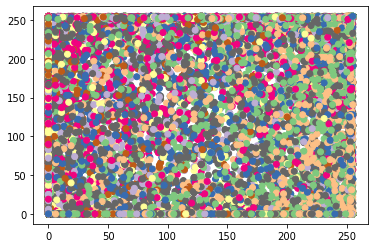

In [ ]:
# Each pixel is a feature, how many features?

# the tensor datatype essentially works like numpy
# can uncomment to convert pytorch tensor to numpy array
X = mnist_train.data#.detach().cpu().numpy()
n,height,width = X.shape
X = X.reshape((n, -1))

# check your answer
print(X.shape)

# can uncomment to convert the labels to numpy
y = mnist_train.targets#.detach().cpu().numpy()

# Let's plot in the space of two pixels. Can you see clear clusters?
plt.scatter(X[:,350], X[:,600], c=y, cmap='Accent')
plt.show()

# 5.2 Neural network model
Each neuron in the network is a logistic unit with activation function:

$h_{\theta}(x)=\frac{1}{1+e^{-\theta^T x}}$

In [ ]:
# define a sigmoid function
def sigmoid(x):
  return 1/(1+np.exp(-x))

# define a logistic unit (neuron)
def neuron(x, theta):
  # add 1 as the first element
  x = np.insert(x, 0, 1)
  z = np.dot(x, theta)
  return sigmoid(z)

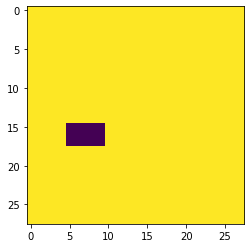

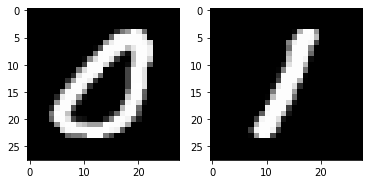

0.0
0.9933071490757153


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
theta = np.zeros((28,28))
theta[15:18,5:10] = -1

# make some sense of theta
plt.imshow(theta)
plt.show()

# now prepare theta for computing neuron function (vectorize and add bias)
bias = 5
theta = np.insert(theta.flatten(), 0, bias)

# select two data
ind1 = 689
ind2 = 765
x1 = X[ind1,:]
x2 = X[ind2,:]

# visualize x1 and x2
plt.subplot(1,2,1)
plt.imshow(x1.reshape(height, width), cmap=plt.get_cmap('gray'))
plt.subplot(1,2,2)
plt.imshow(x2.reshape(height, width), cmap=plt.get_cmap('gray'))

# show the plot
plt.show()

print(neuron(x1, theta))
print(neuron(x2, theta))

Pytorch is a python library providing rich tools for tensor computation and (deep) neural networks. The low-level computations are usually taken care of by the package, and so we only need to decide and program on the high-level parameters (like LEGOs). But it would be important to understand the math behind. To start off with, let's make a simple layer with n inputs and m outputs (the linear sum without activation).

In [ ]:
# number of inputs
n = 3
# number of outputs
m = 2

layer = nn.Linear(n, m)

In [ ]:
# now we setup a simple network, let's take a look at what it has
print(layer)
print(layer.weight)
print(layer.bias)

# what are the rows and columns of weights?

Linear(in_features=3, out_features=2, bias=True)
Parameter containing:
tensor([[-0.2089,  0.5564, -0.3058],
        [ 0.3731,  0.3983,  0.2503]], requires_grad=True)
Parameter containing:
tensor([-0.4282,  0.1467], requires_grad=True)


In [ ]:
# create an input vector
x = torch.ones((3,))
print("input = :\n", x)

input = :
 tensor([1., 1., 1.])


In [ ]:
# we can evaluate the output through the network with the input using forward() function
print("output = :\n", layer.forward(x))
# we can also simply feed x into layer and it should do the same thing as forward()
print(layer(x))

output = :
 tensor([-0.3865,  1.1684], grad_fn=<AddBackward0>)
tensor([-0.3865,  1.1684], grad_fn=<AddBackward0>)


In [ ]:
# we should be able to calculate this without using forward()
# using matrix multiplication from torch
print(torch.mm(layer.weight,x.reshape(-1,1))+layer.bias.reshape(-1,1))

# or dot product from numpy (torch.dot won't broadcast correctly as numpy)
print(np.dot(layer.weight.detach().numpy(),x)+layer.bias.detach().numpy()) 

tensor([[-0.3865],
        [ 1.1684]], grad_fn=<AddBackward0>)
[-0.38651973  1.1683877 ]


The basic elements (layers) can be assembled into a neural network of multiple layers using the nn.Module class. A class is a tempolate for creating objects within which one can define relevant variables and functions.

In [ ]:
# A simplest network consists of a nn.Linear layer and an activition function
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(2,1)    # self.linear is used locally
    self.activation = nn.Sigmoid()  # self.activation is used locally
  
  def forward(self, x):
    o = self.linear(x)      # calculate the linear output
    o = self.activation(o)  # pass the output through the activation function

    return o

In [ ]:
# test this neural network
x = torch.ones((2,))
net = Network()
print(net(x))

tensor([0.3892], grad_fn=<SigmoidBackward0>)


In [ ]:
# now create a two layer neural network with one hidden layer and one output layer
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(3,4)    # first linear layer (hidden)
    self.linear2 = nn.Linear(4,2)    # second linear layer (output)
    self.activation = nn.Sigmoid()  # self.activation is used locally
  
  def forward(self, x):
    h = self.linear1(x)     # calculate the first linear output
    h = self.activation(h)  # pass through the activation function
    o = self.linear2(h)     # calculate the second linear output 
    o = self.activation(o)  # pass through the activation function

    return o

In [ ]:
x = torch.ones((3,))
net = Network()
print(net(x))

tensor([0.4870, 0.4962], grad_fn=<SigmoidBackward0>)


In [ ]:
# an even more compact way is using the nn.Sequential()
# exactly as the Network class defined by nn.Module
net = nn.Sequential(nn.Linear(3,4), nn.Sigmoid(), nn.Linear(4,2), nn.Sigmoid())
print(net(x))

tensor([0.4008, 0.5891], grad_fn=<SigmoidBackward0>)


# 5.3 Gradient descent
The core surrounding model fitting is minimizing a cost function. For linear regression problems, for example, one can calculate the analytical solution for the parameters in one step. However, when the number of features gets larger, the computation can take a very long time. One solution is to do this iteratively through numerical approximation. This practice is widely adopted in training neural networks.

In the follows, you will be solving this problem using gradient descent for a simplest case, the linear regression (replace with commented lines for logistic regression), with one input and one output.

Try different learning rates.

In [3]:
## define the sigmoid function
#def sigmoid(x):
#  return 1/(1+np.exp(-x))

# define the cost function for logistic regression
def cost(h, y):
  # h and y are arrays
  m = len(y)
  #return -(np.dot(np.log(h), y) + np.dot(np.log(1-h), (1-y)))/m
  return np.sum((h - y)**2)/m

# define the gradient (assuming the bias term is 0 and theta is a scalar)
def grad(x,y,theta):
  #return np.dot(x, (sigmoid(theta*x)-y))/len(y)
  return np.dot(x, ((theta*x)-y))/len(y)


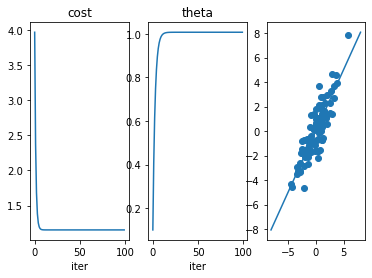

1.007813568299599


In [19]:
# create a random array with positive labeled 1 and negative labeled 0 with noise
x = np.random.normal(0,2,100)
#y = (x+np.random.normal(0,0.2,100))>0
theta_true = 1.0;
y = theta_true * x + np.random.normal(0,1,100)

# initial guess of theta
theta = 0.1

# learning rate
alpha = .1

# number of iterations
iter = 100

# allocate cost function
J = np.zeros((iter,))

# save the updated theta for each iteration
thetas = np.zeros((iter,))

for i in range(iter):
  thetas[i] = theta
  #h = sigmoid(theta*x)
  h = theta*x
  J[i] = cost(h,y)
  dJ = grad(x,y,theta)
  theta = theta - alpha * dJ

plt.subplot(1,3,1)
plt.plot(np.arange(iter), J)
plt.title('cost')
plt.xlabel('iter')

plt.subplot(1,3,2)
plt.plot(np.arange(iter), thetas)
plt.title('theta')
plt.xlabel('iter')

plt.subplot(1,3,3)
xplot = np.linspace(-8,8,num=50)
#plt.plot(xplot, sigmoid(thetas[-1]*xplot))
plt.plot(xplot, thetas[-1]*xplot)
#plt.scatter(x,y,c=y)
plt.scatter(x,y)


plt.show()

# compare with true value of theta
print(thetas[-1])

# 5.4 Word2vec model
The idea of word embedding is representing words by vectors. The vectors are obtained by training neural networks that maximize the probability of all words that occur in the context.

In [1]:
import nltk
import gensim
nltk.download('word2vec_sample')

[nltk_data] Downloading package word2vec_sample to /root/nltk_data...
[nltk_data]   Unzipping models/word2vec_sample.zip.


True

In [2]:
# the model should then be saved to the root:
path = nltk.data.find('/root/nltk_data/models/word2vec_sample/pruned.word2vec.txt')
# load the model
model = gensim.models.KeyedVectors.load_word2vec_format(str(path), binary=False)

In [32]:
# words in the model
print(len(model.index2word))
print(model.index2word[0:10])

43981
['fawn', 'deferment', 'Debts', 'Poetry', 'woods', 'clotted', 'hanging', 'hastily', 'comically', 'localized']


In [30]:
# exemplar word vector
print(model['university'].shape)

(300,)


In [39]:
# visualize the embedding using t-sne
import numpy as np
labels = []
count = 0
max_count = 100
X = np.zeros(shape=(max_count, len(model['university'])))

In [40]:
for key in model.index2word:
  X[count] = model[key]
  labels.append(key)
  count += 1
  if count >= max_count: break

In [41]:
# Reduce to the first 50 PCs
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X_50 = pca.fit_transform(X)

# Using TSNE to further reduce to 2 dimensions
from sklearn.manifold import TSNE
model_tsne = TSNE(n_components=2, random_state=0)
Y = model_tsne.fit_transform(X_50)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


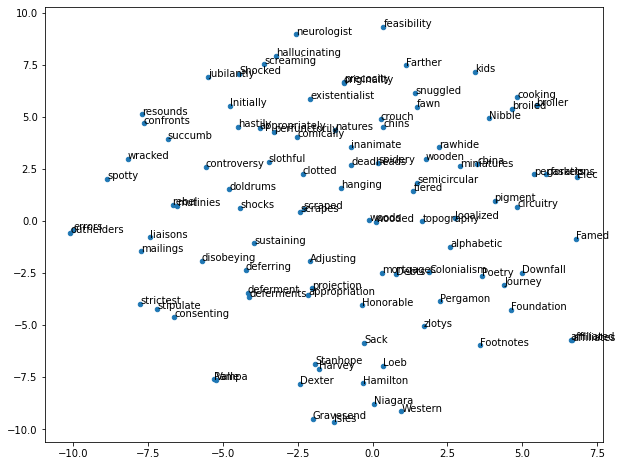

In [44]:
# show the word embeddings
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(Y[:,0], Y[:,1], 20)

# Add labels
for label, x, y in zip(labels, Y[:, 0], Y[:, 1]):
  plt.annotate(label, xy = (x,y), xytext = (0, 0), textcoords = 'offset points', size = 10)

plt.show()

In [45]:
model.most_similar(positive=['cereal'])

[('cereals', 0.7669388055801392),
 ('Cereal', 0.7148815393447876),
 ('oatmeal', 0.591463565826416),
 ('snack', 0.5699782967567444),
 ('milk', 0.5577354431152344),
 ('chocolate', 0.5417346358299255),
 ('sugar', 0.5331320762634277),
 ('ketchup', 0.5263462662696838),
 ('biscuit', 0.5108516216278076),
 ('cashews', 0.5099359154701233)]

In [49]:
# let's try king - man + woman  = queen
model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)

[('queen', 0.7118192911148071)]